# Intro to `jaxcapse`

In this notebook we show how to load and use `jaxcapse`.
Let us start by importing the relevant packages.

In [1]:
import jaxcapse
import jax.numpy as np
import jax
import matplotlib.pyplot as plt
import camb
plt.rcParams['text.usetex'] = True

Initializing neutrino interpolants with dual-grid strategy...
Creating F_interpolant grid...
Creating dFdy_interpolant grid...
F grid: 1100 points from 0.001000 to 1000.0
dFdy grid: 20000 points from 0.001000 to 1000.0
Computing F values...
Computing dFdy values...
Creating Akima interpolators...
Dual-grid interpolants initialized successfully!
jaxcapse: Loading emulators into memory...
  class_mnuw0wacdm: Loaded 4/4 emulators


After importing the relevant packages, we can move to loading the trained emulators. This can be done using the `load_emulator` command and specifying the path to the folder with the trained emulators. We provide some of them in the `jaxcapse` GitHub repo

In [2]:
jaxcapse.trained_emulators

{'class_mnuw0wacdm': {'TT': <jaxcapse.jaxcapse.MLP at 0x75e139da2f90>,
  'TE': <jaxcapse.jaxcapse.MLP at 0x75e134c53d90>,
  'EE': <jaxcapse.jaxcapse.MLP at 0x75e1346d4190>,
  'PP': <jaxcapse.jaxcapse.MLP at 0x75e139d93360>}}

In [3]:
Capse_TT = jaxcapse.trained_emulators["class_mnuw0wacdm"]["TT"]
Capse_EE = jaxcapse.trained_emulators["class_mnuw0wacdm"]["EE"]
Capse_TE = jaxcapse.trained_emulators["class_mnuw0wacdm"]["TE"]
Capse_PP = jaxcapse.trained_emulators["class_mnuw0wacdm"]["PP"]

If you want to have a description of the emulator, just access the `emulator_description` field.
Here you should access to information like:
- Who trained the emulator
- Some additional information (like the Boltzmann solver used to create the training dataset)
- Which cosmological parameter the emulator accepts as input (and in which order!)

In [4]:
Capse_TT.emulator_description

{'author': 'Marco Bonici',
 'author_email': 'bonici.marco@gmail.com',
 'miscellanea': 'The emulator has been trained on the high-precision-settings prediction as computed by the CAMB Boltzmann solver.',
 'parameters': 'ln10As, ns, H0, ωb, ωc, τ'}

If you want to know the training volume for the cosmological parameters, you can access the `in_MinMax` field

In [5]:
Capse_TT.in_MinMax

Array([[2.50003095e+00, 3.49991695e+00],
       [8.80014718e-01, 1.04998643e+00],
       [4.00057329e+01, 9.99951557e+01],
       [1.93302713e-02, 2.53298912e-02],
       [8.00025803e-02, 1.99988491e-01],
       [2.00011015e-02, 1.19990960e-01]], dtype=float64)

Finally, to use the emulators, you need to pass the input cosmological parameters as an array (look at the `emulator_description` to get the correct order!) and pass them to the `get_Cl` method. Feel free to modify these values (but stay within the training volume).

In [6]:
input_test = np.array([3.1, 0.96, 67, 0.02, 0.12, 0.05])  # replace with your input
Cl = Capse_TT.get_Cl(input_test)

In [7]:
Capse_TT.emulator_description

{'author': 'Marco Bonici',
 'author_email': 'bonici.marco@gmail.com',
 'miscellanea': 'The emulator has been trained on the high-precision-settings prediction as computed by the CAMB Boltzmann solver.',
 'parameters': 'ln10As, ns, H0, ωb, ωc, τ'}

`jaxcapse` is fast (but the `Julia` version is faster!)

In [8]:
%timeit Capse_TT.get_Cl(input_test)

52.5 μs ± 1.63 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


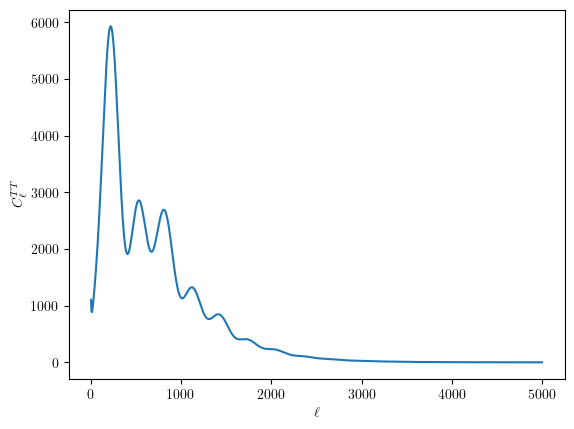

In [9]:
l = np.arange(2, 5000+1)
plt.plot(l, Capse_TT.get_Cl(input_test))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{TT}$');

Using `jax` capabilities, we can differentiate the $C_\ell$ calculation.

In [10]:
jacobian_fn = jax.jit(jax.jacfwd(Capse_TT.get_Cl))#we are using forward differentaition, as the number of output is bigger than the number of inputs
jacobian = jacobian_fn(input_test)

In [11]:
%timeit jacobian_fn(input_test)

337 μs ± 9.03 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


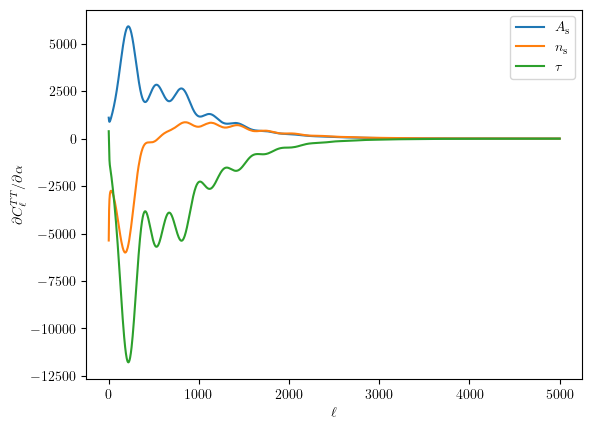

In [12]:
l = np.arange(2, 5000+1)
plt.plot(l, jacobian[:,0], label = r'$A_\mathrm{s}$')
plt.plot(l, jacobian[:,1], label = r'$n_\mathrm{s}$')
plt.plot(l, jacobian[:,5], label = r'$\tau$')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\partial C_\ell^{TT}/\partial \alpha$')
plt.legend();

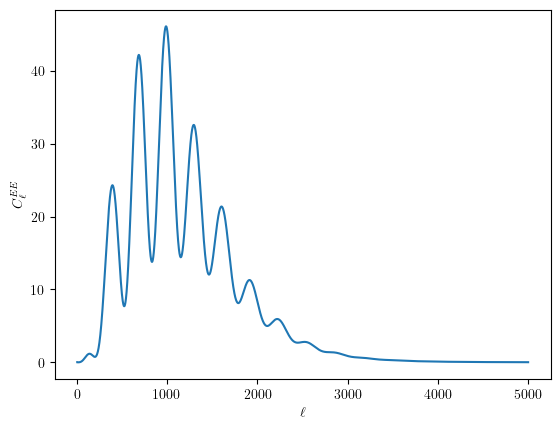

In [13]:
plt.plot(l, Capse_EE.get_Cl(input_test))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{EE}$');

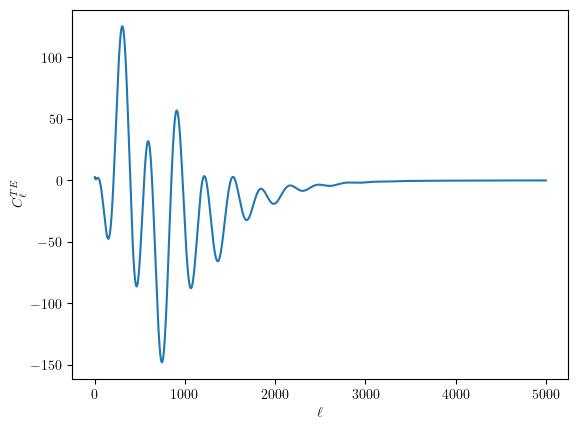

In [14]:
plt.plot(l, Capse_TE.get_Cl(input_test))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{TE}$');

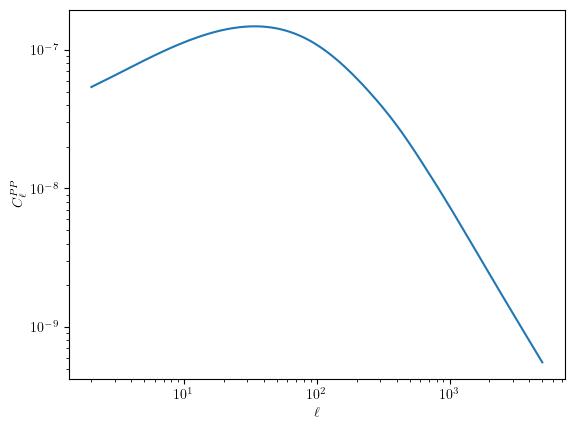

In [15]:
plt.loglog(l, Capse_PP.get_Cl(input_test))
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{PP}$');

In order to show that everything is going in the right way, let us compare with some old-school `CAMB` calculations. Do not modify these settings, as they are the same used for the training of the emulator (and the cosmological parameters are matching those used in computing the $C_\ell$'s with the emulator.

In [16]:
lmax = 10000

# set_for_lmax
lens_potential_accuracy = 8
lens_margin = 2050

# set_matter_power
kmax = 10
k_per_logint = 130
nonlinear = True
accurate_massive_neutrinos = True

# set_accuracy
AccuracyBoost = 2
lSampleBoost = 2
lAccuracyBoost = 2
DoLateRadTruncation = False

pars = camb.CAMBparams()
pars.set_cosmology(H0 = input_test[2],
                ombh2= input_test[3],
                omch2= input_test[4],
                mnu  =0.06,
                omk  =0.,
                tau  = input_test[5],
                Alens=1.,
                neutrino_hierarchy="normal",
                num_massive_neutrinos=1,
                )

pars.InitPower.set_params(As=np.exp(input_test[0])*10**(-10),
                        ns=input_test[1],
                        r=0)
pars.set_for_lmax(lmax,
                lens_potential_accuracy=lens_potential_accuracy)

pars.set_dark_energy(w=-1., wa=0., dark_energy_model="fluid")
pars.WantTransfer = 1
pars.NonLinear = camb.model.NonLinear_both # Non-linear matter power & lensing, HMcode
pars.Transfer.kmax = kmax
pars.Transfer.k_per_logint = k_per_logint
pars.Transfer.accurate_massive_neutrinos = accurate_massive_neutrinos

pars.set_accuracy(AccuracyBoost=AccuracyBoost,
                lSampleBoost=lSampleBoost,
                lAccuracyBoost=lAccuracyBoost,
                DoLateRadTruncation=DoLateRadTruncation)

results = camb.get_results(pars)

powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")

totCL=powers["total"]
unlensedCL=powers["unlensed_scalar"]
lens_potential=powers["lens_potential"]

In [17]:
ll = np.arange(totCL.shape[0])[2:5001]
clTT = totCL[:,0]
clEE = totCL[:,1]
clBB = totCL[:,2]
clTE = totCL[:,3]
clPP = lens_potential[:,0]

We can now compare `jaxcapse` with `CAMB`

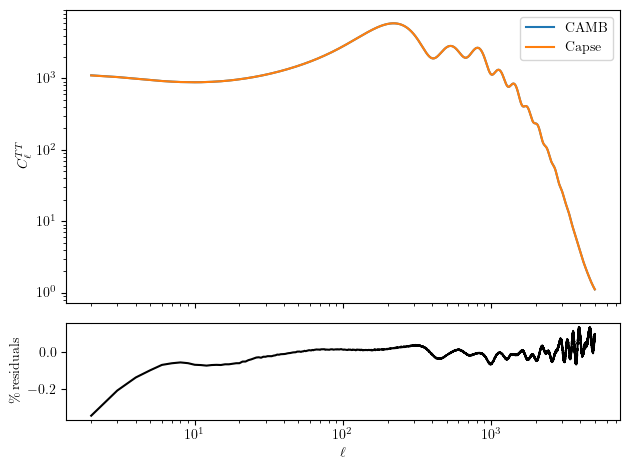

In [18]:
camb   = clTT[2:5001]              # CAMB C_ℓ
capse  = Capse_TT.get_Cl(input_test)  # Capse C_ℓ
ratio  = camb / capse  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(ll, camb, label=r'$\mathrm{CAMB}$')
ax_top.loglog(ll, capse, label=r'$\mathrm{Capse}$')
ax_top.set_ylabel(r'$C_\ell^{TT}$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(ll, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$\ell$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

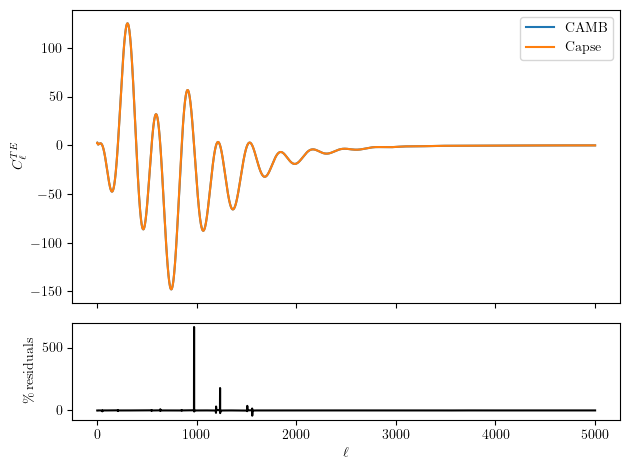

In [19]:
camb   = clTE[2:5001]              # CAMB C_ℓ
capse  = Capse_TE.get_Cl(input_test)  # Capse C_ℓ
ratio  = camb / capse  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(ll, camb, label=r'$\mathrm{CAMB}$')
ax_top.plot(ll, capse, label=r'$\mathrm{Capse}$')
ax_top.set_ylabel(r'$C_\ell^{TE}$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(ll, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$\ell$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

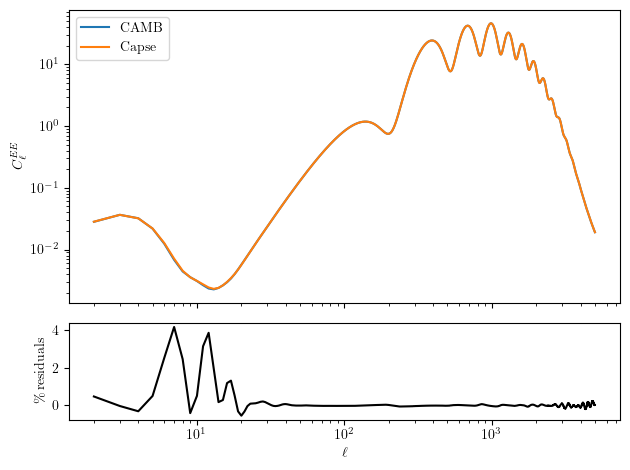

In [20]:
camb   = clEE[2:5001]              # CAMB C_ℓ
capse  = Capse_EE.get_Cl(input_test)  # Capse C_ℓ
ratio  = camb / capse  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(ll, camb, label=r'$\mathrm{CAMB}$')
ax_top.loglog(ll, capse, label=r'$\mathrm{Capse}$')
ax_top.set_ylabel(r'$C_\ell^{EE}$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(ll, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$\ell$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()

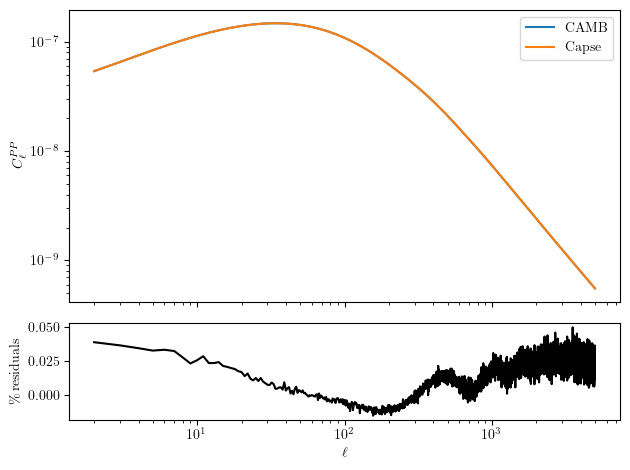

In [21]:
camb   = clPP[2:5001]              # CAMB C_ℓ
capse  = Capse_PP.get_Cl(input_test)  # Capse C_ℓ
ratio  = camb / capse  

fig, (ax_top, ax_bot) = plt.subplots(
    2, 1,
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]},  # top three times taller
)

# ─── Top panel: power spectra ────────────────────────────────
ax_top.plot(ll, camb, label=r'$\mathrm{CAMB}$')
ax_top.loglog(ll, capse, label=r'$\mathrm{Capse}$')
ax_top.set_ylabel(r'$C_\ell^{PP}$')
ax_top.legend()

# ─── Bottom panel: ratio ─────────────────────────────────────
ax_bot.plot(ll, 100*(1-ratio), color='k')
ax_bot.set_xlabel(r'$\ell$')
ax_bot.set_ylabel(r'$\%\,\mathrm{residuals}$')

plt.tight_layout()
plt.show()